<a href="https://colab.research.google.com/github/kumuds4/BCH/blob/master/Making_the_Most_of_your_Colab_Subscription.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Making the Most of your Colab Subscription



## Faster GPUs

Users who have purchased one of Colab's paid plans have access to faster GPUs and more memory. You can upgrade your notebook's GPU settings in `Runtime > Change runtime type` in the menu to select from several accelerator options, subject to availability.

The free of charge version of Colab grants access to Nvidia's T4 GPUs subject to quota restrictions and availability.

You can see what GPU you've been assigned at any time by executing the following cell. If the execution result of running the code cell below is "Not connected to a GPU", you can change the runtime by going to `Runtime > Change runtime type` in the menu to enable a GPU accelerator, and then re-execute the code cell.


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

In order to use a GPU with your notebook, select the `Runtime > Change runtime type` menu, and then set the hardware accelerator to the desired option.

## More memory

Users who have purchased one of Colab's paid plans have access to high-memory VMs when they are available. More powerful GPUs are always offered with high-memory VMs.



You can see how much memory you have available at any time by running the following code cell. If the execution result of running the code cell below is "Not using a high-RAM runtime", then you can enable a high-RAM runtime via `Runtime > Change runtime type` in the menu. Then select High-RAM in the Runtime shape toggle button. After, re-execute the code cell.


In [ ]:
import psutil

ram_gb = psutil.virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

## Longer runtimes

All Colab runtimes are reset after some period of time (which is faster if the runtime isn't executing code). Colab Pro and Pro+ users have access to longer runtimes than those who use Colab free of charge.

## Background execution

Colab Pro+ users have access to background execution, where notebooks will continue executing even after you've closed a browser tab. This is always enabled in Pro+ runtimes as long as you have compute units available.



## Relaxing resource limits in Colab Pro

Your resources are not unlimited in Colab. To make the most of Colab, avoid using resources when you don't need them. For example, only use a GPU when required and close Colab tabs when finished.



If you encounter limitations, you can relax those limitations by purchasing more compute units via Pay As You Go. Anyone can purchase compute units via [Pay As You Go](https://colab.research.google.com/signup); no subscription is required.

## Send us feedback!

If you have any feedback for us, please let us know. The best way to send feedback is by using the Help > 'Send feedback...' menu. If you encounter usage limits in Colab Pro consider subscribing to Pro+.

If you encounter errors or other issues with billing (payments) for Colab Pro, Pro+, or Pay As You Go, please email [colab-billing@google.com](mailto:colab-billing@google.com).

## More Resources

### Working with Notebooks in Colab
- [Overview of Colab](/notebooks/basic_features_overview.ipynb)
- [Guide to Markdown](/notebooks/markdown_guide.ipynb)
- [Importing libraries and installing dependencies](/notebooks/snippets/importing_libraries.ipynb)
- [Saving and loading notebooks in GitHub](https://colab.research.google.com/github/googlecolab/colabtools/blob/main/notebooks/colab-github-demo.ipynb)
- [Interactive forms](/notebooks/forms.ipynb)
- [Interactive widgets](/notebooks/widgets.ipynb)

<a name="working-with-data"></a>
### Working with Data
- [Loading data: Drive, Sheets, and Google Cloud Storage](/notebooks/io.ipynb)
- [Charts: visualizing data](/notebooks/charts.ipynb)
- [Getting started with BigQuery](/notebooks/bigquery.ipynb)

### Machine Learning Crash Course
These are a few of the notebooks from Google's online Machine Learning course. See the [full course website](https://developers.google.com/machine-learning/crash-course/) for more.
- [Intro to Pandas DataFrame](https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/pandas_dataframe_ultraquick_tutorial.ipynb)
- [Linear regression with tf.keras using synthetic data](https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/linear_regression_with_synthetic_data.ipynb)


<a name="using-accelerated-hardware"></a>
### Using Accelerated Hardware
- [TensorFlow with GPUs](/notebooks/gpu.ipynb)
- [TPUs in Colab](/notebooks/tpu.ipynb)

<a name="machine-learning-examples"></a>

## Machine Learning Examples

To see end-to-end examples of the interactive machine learning analyses that Colab makes possible, check out these tutorials using models from [TensorFlow Hub](https://tfhub.dev).

A few featured examples:

- [Retraining an Image Classifier](https://tensorflow.org/hub/tutorials/tf2_image_retraining): Build a Keras model on top of a pre-trained image classifier to distinguish flowers.
- [Text Classification](https://tensorflow.org/hub/tutorials/tf2_text_classification): Classify IMDB movie reviews as either *positive* or *negative*.
- [Style Transfer](https://tensorflow.org/hub/tutorials/tf2_arbitrary_image_stylization): Use deep learning to transfer style between images.
- [Multilingual Universal Sentence Encoder Q&A](https://tensorflow.org/hub/tutorials/retrieval_with_tf_hub_universal_encoder_qa): Use a machine learning model to answer questions from the SQuAD dataset.
- [Video Interpolation](https://tensorflow.org/hub/tutorials/tweening_conv3d): Predict what happened in a video between the first and the last frame.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
#latest modification
#RM-polar codes and machine learning simulations
#06/21/2025
import numpy as np
import matplotlib.pyplot as plt
import heapq
import torch
# Imports
import tensorflow as tf

# Ensure TensorFlow uses the GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Set memory growth for GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import Adam
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader # Import necessary PyTorch data utilities

#################################################################################

#Lates RM-polar
# Configuration
# ---- Configuration ----
BLOCK_LENGTH = 128
INFO_BITS = 64
RM_ORDER = 3
SNR_RANGE = np.arange(0, 7, 0.5)
LIST_SIZES = [1, 8, 16, 32]
NUM_FRAMES = 20000
BATCH_SIZE = 64
EPOCHS = 30
LEARNING_RATE = 0.001  # Add this for clarity
SNR_DB = 2.0  # Signal-to-noise ratio in dB

# BPSK Modulation and AWGN Channel
def bpsk_modulate(x):
    return 1 - 2 * x

def awgn_noise(x, snr_db, rate):
    snr_linear = 10 ** (snr_db / 10)
    sigma = np.sqrt(1 / (2 * rate * snr_linear))
    return x + sigma * np.random.randn(*x.shape)

def llr_awgn(y, snr_db, rate):
    snr_linear = 10 ** (snr_db / 10)
    sigma2 = 1 / (2 * rate * snr_linear)
    return 2 * y / sigma2

# RM-Polar Construction
def get_rm_polar_frozen_indices(N, K, rm_order):
    n = int(np.log2(N))
    indices = np.arange(N)
    bin_indices = np.array([list(np.binary_repr(i, n)) for i in indices], dtype=int)
    hamming_weights = bin_indices.sum(axis=1)
    rm_candidates = indices[hamming_weights >= rm_order]

    # Bhattacharyya parameters (assuming perfect channel)
    Z = np.zeros(N)
    Z[0] = 2 ** n
    for i in range(1, N):
        Z[i] = Z[i // 2] / 2 if i % 2 == 0 else (Z[i // 2 - 1] + Z[i // 2]) / 2

    polar_order = np.argsort(Z)
    filtered = [i for i in polar_order if i in rm_candidates]
    info_indices = np.array(filtered[:K])
    frozen_indices = np.setdiff1d(np.arange(N), info_indices)
    return frozen_indices

# Polar Encoder
def polar_encode(u, frozen_indices):
    N = len(frozen_indices) + len(u)
    x = np.zeros(N, dtype=int)
    info_idx = np.setdiff1d(np.arange(N), frozen_indices)
    x[info_idx] = u
    n = int(np.log2(N))
    for i in range(n):
        step = 2 ** i
        for j in range(0, N, 2 * step):
            for k in range(step):
                x[j + k] ^= x[j + k + step]
    return x

# SC Decoder
def sc_decode(llr, frozen_indices):
    N = len(llr)
    u_hat = np.zeros(N, dtype=int)
    info_idx = np.setdiff1d(np.arange(N), frozen_indices)
    u_hat[frozen_indices] = 0
    u_hat[info_idx] = (llr[info_idx] < 0).astype(int)
    return u_hat[info_idx]

##################################################################################
if _ == 0:
    print(f"[DEBUG] SNR: {snr}")
    print(f"[DEBUG] LLR min/max: {llrs.min()}/{llrs.max()}")
#####################################################################################
# SCL Decoder
def scl_decode(llr, frozen_indices, L):
    N = len(llr)
    paths = [(0.0, np.zeros(N, dtype=int))]
    info_idx = np.setdiff1d(np.arange(N), frozen_indices)
    for i in range(N):
        new_paths = []
        for pm, u in paths:
            if i in frozen_indices:
                u0 = u.copy()
                u0[i] = 0
                pm_new = pm + np.log1p(np.exp(-abs(llr[i])))
                new_paths.append((pm_new, u0))
            else:
                for bit in [0, 1]:
                    u_new = u.copy()
                    u_new[i] = bit
                    llr_i = llr[i]
                    pm_new = pm + (np.log1p(np.exp(-abs(llr_i))) if bit != (llr_i < 0) else 0)
                    new_paths.append((pm_new, u_new))
        paths = heapq.nsmallest(L, new_paths)
    best_path = min(paths, key=lambda x: x[0])[1]
    return best_path[info_idx]

# RM-Polar Code Class
class RMPolarCode:
    def __init__(self, N=128, K=64, rm_order=3, snr_db=2.0):  # Correct setup
        self.N = N
        self.K = K
        self.rm_order = rm_order
        self.rate = K / N
        self.snr_db = snr_db  # Initialize snr_db
        self.frozen_indices = get_rm_polar_frozen_indices(N, K, rm_order)

    def polar_encode(self, u):
        return polar_encode(u, self.frozen_indices)

    def calculate_mi(self, snr_db):
        self.snr_db = snr_db  # Optionally set snr_db
        snr_linear = 10 ** (snr_db / 10)
        return 0.5 * np.log2(1 + snr_linear * self.rate)



###############################################################################

# Define your RNN model with the correct input size
class RNNDecoder(nn.Module):
    def __init__(self, input_size=1, hidden_size=128, output_size=64):
        super(RNNDecoder, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
     output, _ = self.lstm(x)
     output = self.fc(output[:, -1, :])
     return torch.sigmoid(output)  # Apply sigmoid activation
# ---- RNN Decoder ----
##########################################################################
#latest train decoder
def train_rnn_decoder(code, train_loader, val_loader, test_loader, epochs=30, lr=0.001, device='cpu'):
    model = RNNDecoder(input_size=1, hidden_size=128, output_size=code.K).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCELoss()
    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for batch_X, batch_Y in train_loader:
            batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)
            optimizer.zero_grad()
            preds = torch.sigmoid(model(batch_X))  # Apply sigmoid to output
            print(f"Train Preds shape: {preds.shape}, Targets shape: {batch_Y.shape}")  # Debug shapes
            print(f"Preds min/max: {preds.min()}/{preds.max()}")  # Debug values
            loss = criterion(preds, batch_Y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        train_losses.append(epoch_loss / len(train_loader))

        model.eval()
        with torch.no_grad():
            val_loss = 0
            for val_X, val_Y in val_loader:
                val_X, val_Y = val_X.to(device), val_Y.to(device)
                val_preds = torch.sigmoid(model(val_X))  # Apply sigmoid to output
                print(f"Val Preds shape: {val_preds.shape}, Targets shape: {val_Y.shape}")  # Debug shapes
                loss = criterion(val_preds, val_Y)
                val_loss += loss.item()
            val_losses.append(val_loss / len(val_loader))

        print(f"Epoch {epoch+1}: Train Loss={train_losses[-1]:.4f}, Val Loss={val_losses[-1]:.4f}")

    return model, train_losses, val_losses
###########################################################################

# ---- ML Decoder Utilities ----

#Latest data loader

# Reshape data in get_dataloaders to match the expected input size

###################################################################



def generate_data(num_samples, timesteps, features):
    X = np.random.randn(num_samples, timesteps, features)
    y = np.random.randint(0, 2, (num_samples, 1))
    return X, y

# Data preparation
timesteps = 10  # Example number of timesteps
features = 3    # Number of features, e.g., BPSK, SNR, etc.
X_train, y_train = generate_data(1000, timesteps, features)
X_val, y_val = generate_data(200, timesteps, features)
X_test, y_test = generate_data(200, timesteps, features)

# RNN Model Configuration
model = Sequential()
model.add(LSTM(128, input_shape=(timesteps, features), return_sequences=False))
model.add(Dense(1, activation='sigmoid'))

# Compile Model
learning_rate = 0.001
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

# Train Model
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))

# Prediction & Calculating BER and BLER
def calculate_ber(y_true, y_pred):
    errors = np.sum(y_true != y_pred)
    total_bits = y_true.size
    return errors / total_bits

def calculate_bler(y_true, y_pred):
    block_errors = np.sum(np.any(y_true != y_pred, axis=1))
    num_blocks = y_true.shape[0]
    return block_errors / num_blocks

# Make Predictions
y_pred_probs = model.predict(X_test)
y_pred = np.round(y_pred_probs)

ber = calculate_ber(y_test, y_pred)
bler = calculate_bler(y_test, y_pred)

print(f"BER: {ber}, BLER: {bler}")

#######################################################
# Reshape data in get_dataloaders to match the expected input size
def get_dataloaders(code, batch_size):
    num_samples_train = 10000
    num_samples_val = 1000
    num_samples_test = 1000

    # Simulate data
    X_train = np.random.randn(num_samples_train, code.N).reshape(-1, code.N, 1)
    y_train = np.random.randint(0, 2, (num_samples_train, code.K))

    X_val = np.random.randn(num_samples_val, code.N).reshape(-1, code.N, 1)
    y_val = np.random.randint(0, 2, (num_samples_val, code.K))

    X_test = np.random.randn(num_samples_test, code.N).reshape(-1, code.N, 1)
    y_test = np.random.randint(0, 2, (num_samples_test, code.K))

    # Create TensorDatasets
    train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
    val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))
    test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader
####################################################

#####################################################
#latest evaluator
def evaluate_decoder(code, decoder_func, snrs, L=1, model=None, device='cpu'):
    frozen_indices = code.frozen_indices
    rate = code.rate
    ber_curve, bler_curve = [], []
    for snr in snrs:
        bit_errors, block_errors, total_bits = 0, 0, 0
        for _ in range(NUM_FRAMES):
            u = np.random.randint(0, 2, code.K)
            x = code.polar_encode(u)
            y = bpsk_modulate(x)
            y_noisy = awgn_noise(y, snr, rate)
            llrs = llr_awgn(y_noisy, snr, rate)
            if decoder_func == "sc":
                u_hat = sc_decode(llrs, frozen_indices)
            elif decoder_func == "scl":
                u_hat = scl_decode(llrs, frozen_indices, L)
            elif decoder_func == "rnn" and model is not None:
                y_noisy_tensor = torch.tensor(y_noisy, dtype=torch.float32).to(device)
                u_hat = model(y_noisy_tensor.unsqueeze(0)).squeeze().round().cpu().numpy()
            else:
                raise ValueError("Invalid decoder function or model missing for RNN")
            bit_errors += np.sum(u != u_hat)
            block_errors += int(not np.array_equal(u, u_hat))
            total_bits += code.K
        ber_curve.append(bit_errors / total_bits)
        bler_curve.append(block_errors / NUM_FRAMES)
        print(f"SNR={snr:.1f} dB: BER={ber_curve[-1]:.2e}, BLER={bler_curve[-1]:.2e}")
    return ber_curve, bler_curve
######################################################
#Latest main()
def main():

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Initialize the RMPolarCode with snr_db
    code = RMPolarCode(N=BLOCK_LENGTH, K=INFO_BITS, rm_order=RM_ORDER, snr_db=SNR_DB)

    # Prepare data loaders
    train_loader, val_loader, test_loader = get_dataloaders(code, batch_size=BATCH_SIZE)

    # Train and Evaluate RNN Decoder
    model, train_losses, val_losses = train_rnn_decoder(
        code, train_loader, val_loader, test_loader, epochs=EPOCHS, lr=LEARNING_RATE, device=device
    )





   # model, train_losses, val_losses = train_rnn_decoder(code, train_loader, val_loader, epochs=EPOCHS, device=device)

    print("Running SC decoder...")
    ber_sc, bler_sc = evaluate_decoder(code, decoder_func="sc", snrs=SNR_RANGE)

    ber_scl_all, bler_scl_all = {}, {}
    for L in LIST_SIZES:
        print(f"Running SCL decoder with list size {L}...")
        ber_scl, bler_scl = evaluate_decoder(code, decoder_func="scl", snrs=SNR_RANGE, L=L)
        ber_scl_all[L] = ber_scl
        bler_scl_all[L] = bler_scl

    print("Evaluating RNN Decoder...")
    ber_rnn, bler_rnn = evaluate_decoder(code, decoder_func="rnn", snrs=SNR_RANGE, model=model, device=device)

    # Plot Training/Validation Loss
    plt.figure()
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.grid(True)
    plt.legend()
    plt.show()

    # Plot BER Comparison
    plt.figure()
    plt.semilogy(SNR_RANGE, ber_sc, label="SC")
    for L in LIST_SIZES:
        plt.semilogy(SNR_RANGE, ber_scl_all[L], label=f"SCL L={L}")
    plt.semilogy(SNR_RANGE, ber_rnn, label="RNN")
    plt.xlabel("SNR (dB)")
    plt.ylabel("BER")
    plt.ylim(1e-6, 1)
    plt.title("Bit Error Rate Comparison")
    plt.grid(True)
    plt.legend()
    plt.show()

    # Plot BLER Comparison
    plt.figure()
    plt.semilogy(SNR_RANGE, bler_sc, label="SC")
    for L in LIST_SIZES:
        plt.semilogy(SNR_RANGE, bler_scl_all[L], label=f"SCL L={L}")
    plt.semilogy(SNR_RANGE, bler_rnn, label="RNN")
    plt.xlabel("SNR (dB)")
    plt.ylabel("BLER")
    plt.ylim(1e-6, 1)
    plt.title("Block Error Rate Comparison")
    plt.grid(True)
    plt.legend()
    plt.show()

    # Plot Mutual Information
    plt.figure()
    mi_values = [code.calculate_mi(snr) for snr in SNR_RANGE]
    plt.plot(SNR_RANGE, mi_values, label='Mutual Information')
    plt.xlabel('SNR (dB)')
    plt.ylabel('Mutual Information (bits)')
    plt.title('Mutual Information vs. SNR')
    plt.grid(True)
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main()
######################################################



TensorFlow GPU memory growth enabled.
Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5147 - loss: 0.6939 - val_accuracy: 0.5500 - val_loss: 0.6888
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5522 - loss: 0.6857 - val_accuracy: 0.5400 - val_loss: 0.6870
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5207 - loss: 0.6932 - val_accuracy: 0.5400 - val_loss: 0.6870
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5684 - loss: 0.6770 - val_accuracy: 0.5450 - val_loss: 0.6837
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5642 - loss: 0.6831 - val_accuracy: 0.5300 - val_loss: 0.6872
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5634 - loss: 0.6809 - val_accuracy: 0.5450 - val_loss: 0.6869
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5594 - loss: 0.6783 - val_accuracy: 0.5400 - val_loss: 0.6848
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5511 - loss: 0.

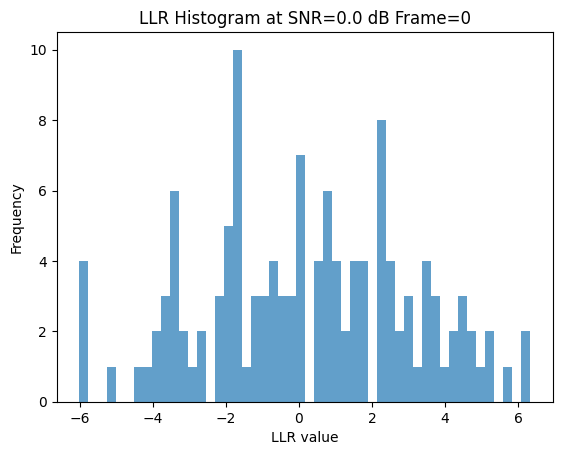

[DEBUG] SNR=0.0 dB, Frame=1
[DEBUG] LLR min/max: -5.986/6.666


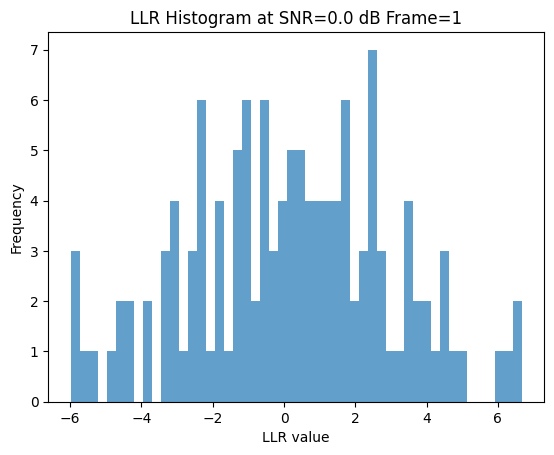

[DEBUG] SNR=0.0 dB, Frame=2
[DEBUG] LLR min/max: -6.801/6.618


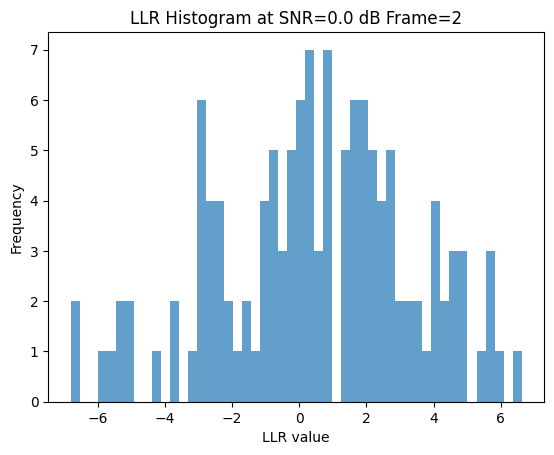

SNR=0.0 dB: BER=4.58e-01, BLER=1.00e+00
[DEBUG] SNR=0.5 dB, Frame=0
[DEBUG] LLR min/max: -5.877/7.571


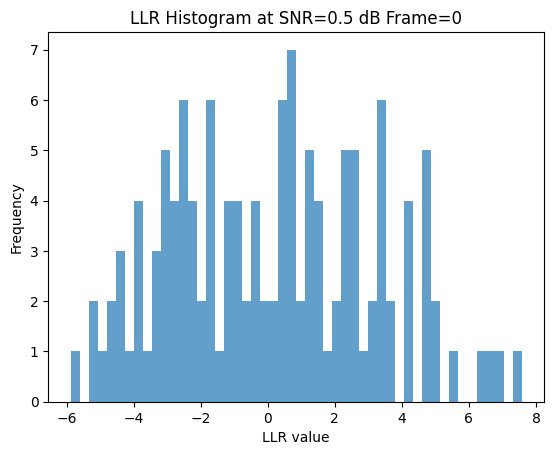

[DEBUG] SNR=0.5 dB, Frame=1
[DEBUG] LLR min/max: -7.019/9.254


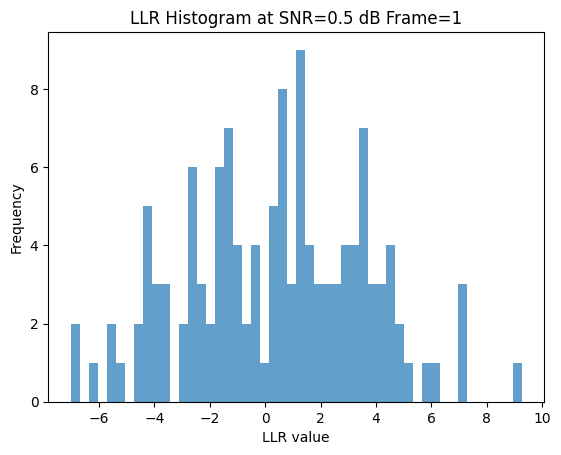

[DEBUG] SNR=0.5 dB, Frame=2
[DEBUG] LLR min/max: -6.753/8.320


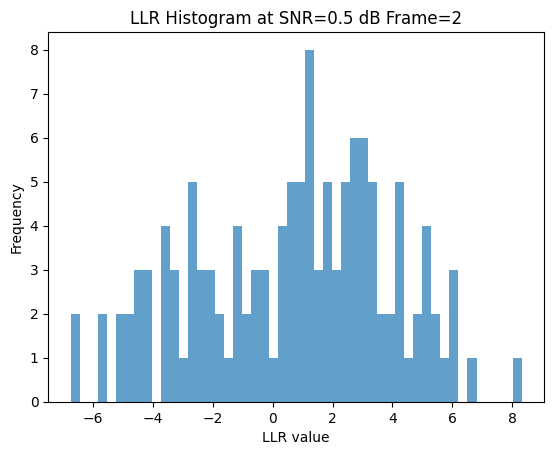

SNR=0.5 dB: BER=4.58e-01, BLER=1.00e+00
[DEBUG] SNR=1.0 dB, Frame=0
[DEBUG] LLR min/max: -7.834/6.606


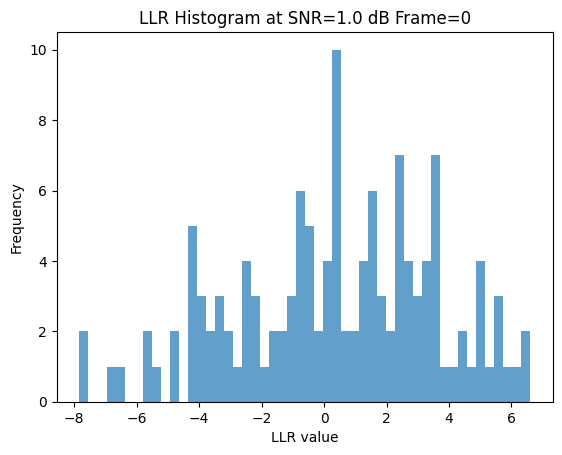

[DEBUG] SNR=1.0 dB, Frame=1
[DEBUG] LLR min/max: -7.164/7.706


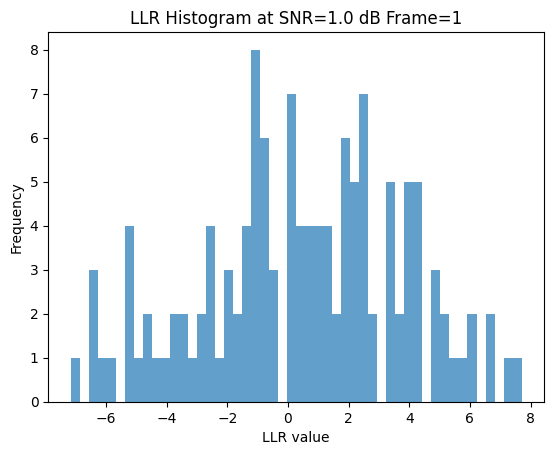

[DEBUG] SNR=1.0 dB, Frame=2
[DEBUG] LLR min/max: -6.279/7.145


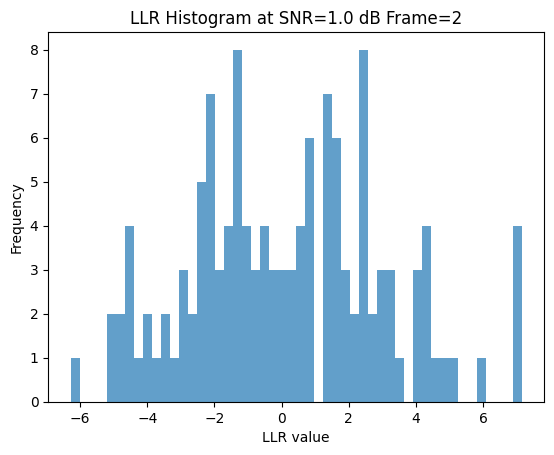

SNR=1.0 dB: BER=4.56e-01, BLER=1.00e+00
SNR=1.5 dB: BER=4.66e-01, BLER=1.00e+00
SNR=2.0 dB: BER=4.46e-01, BLER=1.00e+00
SNR=2.5 dB: BER=4.42e-01, BLER=1.00e+00
SNR=3.0 dB: BER=4.51e-01, BLER=1.00e+00
SNR=3.5 dB: BER=4.53e-01, BLER=1.00e+00
SNR=4.0 dB: BER=4.42e-01, BLER=1.00e+00
SNR=4.5 dB: BER=4.47e-01, BLER=1.00e+00
SNR=5.0 dB: BER=4.34e-01, BLER=1.00e+00
SNR=5.5 dB: BER=4.36e-01, BLER=1.00e+00
SNR=6.0 dB: BER=4.38e-01, BLER=1.00e+00
SNR=6.5 dB: BER=4.48e-01, BLER=1.00e+00
Running SCL decoder with list size 1...
[DEBUG] SNR=0.0 dB, Frame=0
[DEBUG] LLR min/max: -7.680/6.009


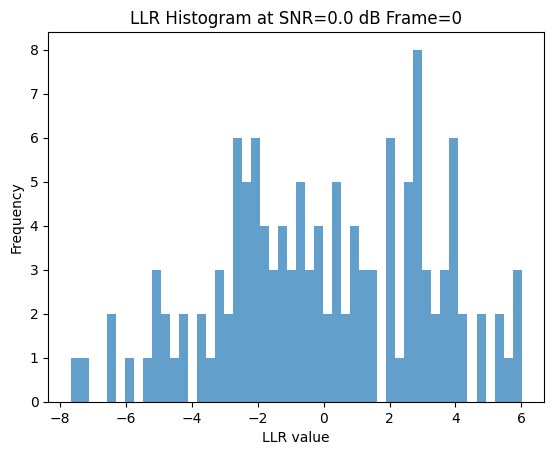

[DEBUG] SNR=0.0 dB, Frame=1
[DEBUG] LLR min/max: -6.822/6.517


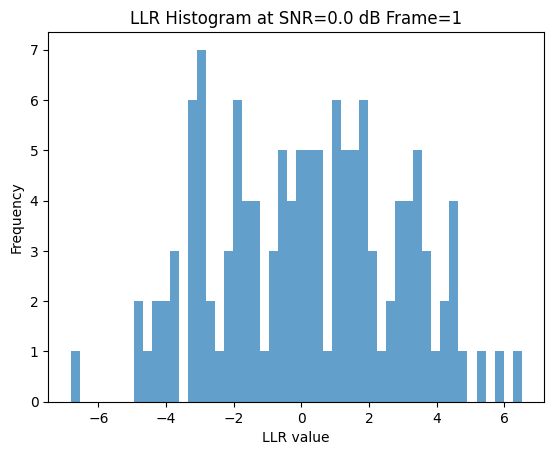

[DEBUG] SNR=0.0 dB, Frame=2
[DEBUG] LLR min/max: -7.024/5.443


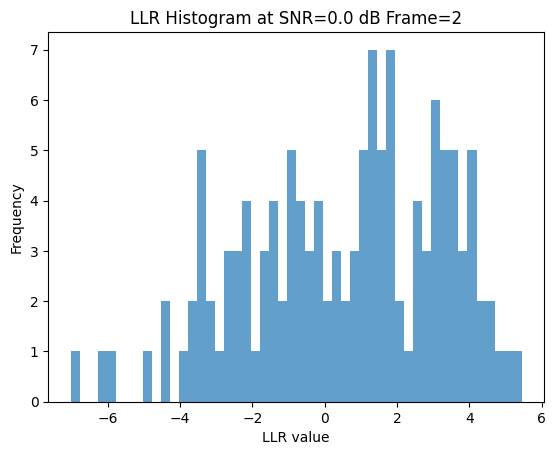

SNR=0.0 dB: BER=4.60e-01, BLER=1.00e+00
[DEBUG] SNR=0.5 dB, Frame=0
[DEBUG] LLR min/max: -7.088/8.276


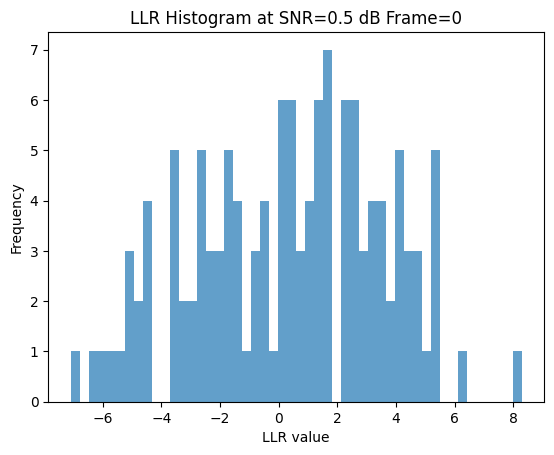

[DEBUG] SNR=0.5 dB, Frame=1
[DEBUG] LLR min/max: -6.633/7.602


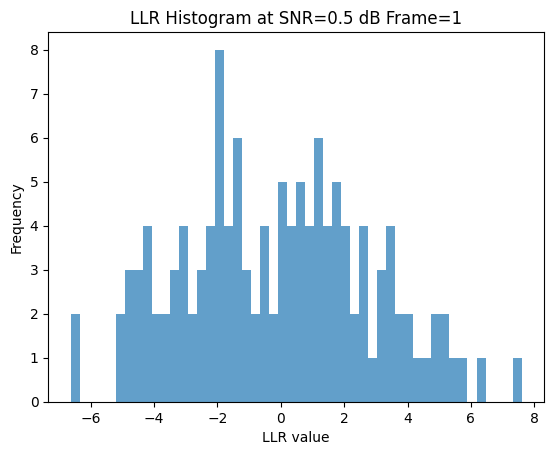

[DEBUG] SNR=0.5 dB, Frame=2
[DEBUG] LLR min/max: -7.941/9.258


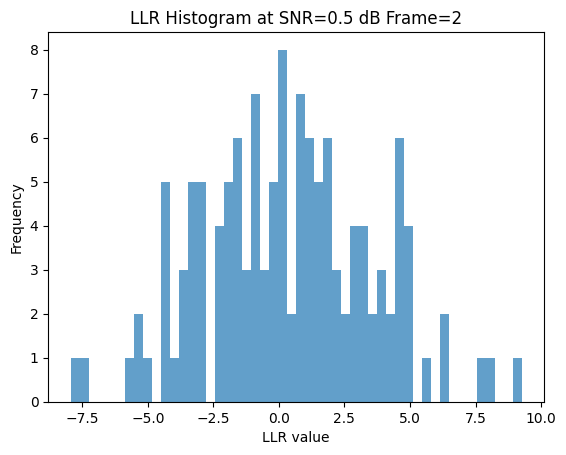

SNR=0.5 dB: BER=4.50e-01, BLER=1.00e+00
[DEBUG] SNR=1.0 dB, Frame=0
[DEBUG] LLR min/max: -8.085/6.210


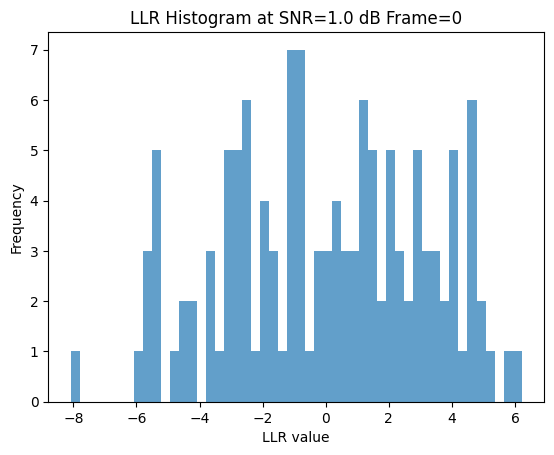

[DEBUG] SNR=1.0 dB, Frame=1
[DEBUG] LLR min/max: -7.469/6.673


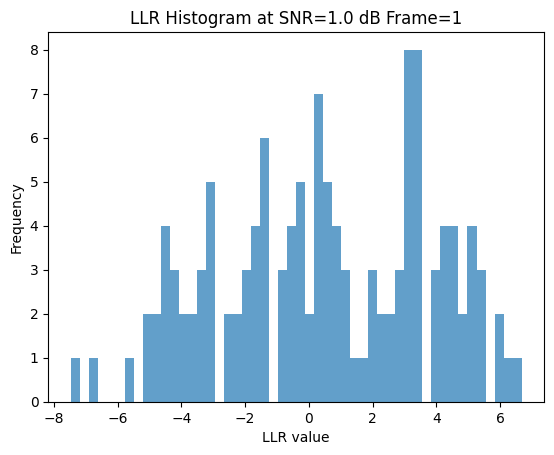

[DEBUG] SNR=1.0 dB, Frame=2
[DEBUG] LLR min/max: -7.839/8.092


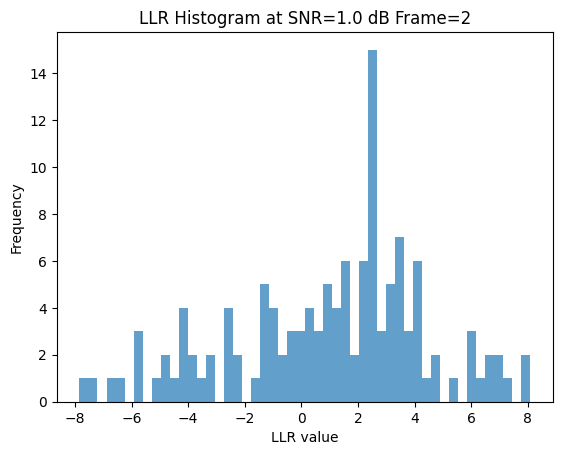

SNR=1.0 dB: BER=4.52e-01, BLER=1.00e+00
SNR=1.5 dB: BER=4.53e-01, BLER=1.00e+00
SNR=2.0 dB: BER=4.38e-01, BLER=1.00e+00
SNR=2.5 dB: BER=4.41e-01, BLER=1.00e+00
SNR=3.0 dB: BER=4.50e-01, BLER=1.00e+00
SNR=3.5 dB: BER=4.40e-01, BLER=1.00e+00
SNR=4.0 dB: BER=4.44e-01, BLER=1.00e+00
SNR=4.5 dB: BER=4.44e-01, BLER=1.00e+00
SNR=5.0 dB: BER=4.44e-01, BLER=1.00e+00
SNR=5.5 dB: BER=4.43e-01, BLER=1.00e+00
SNR=6.0 dB: BER=4.41e-01, BLER=1.00e+00
SNR=6.5 dB: BER=4.35e-01, BLER=1.00e+00
Running SCL decoder with list size 8...
[DEBUG] SNR=0.0 dB, Frame=0
[DEBUG] LLR min/max: -6.630/5.855


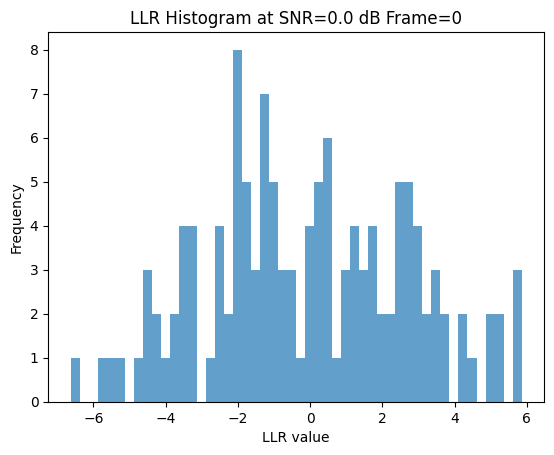

[DEBUG] SNR=0.0 dB, Frame=1
[DEBUG] LLR min/max: -6.325/7.155


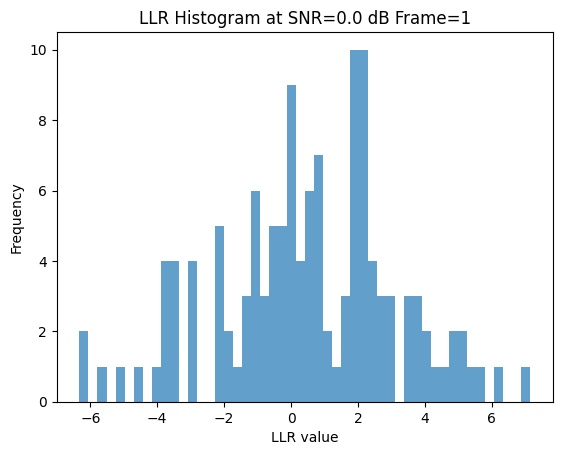

[DEBUG] SNR=0.0 dB, Frame=2
[DEBUG] LLR min/max: -6.389/6.336


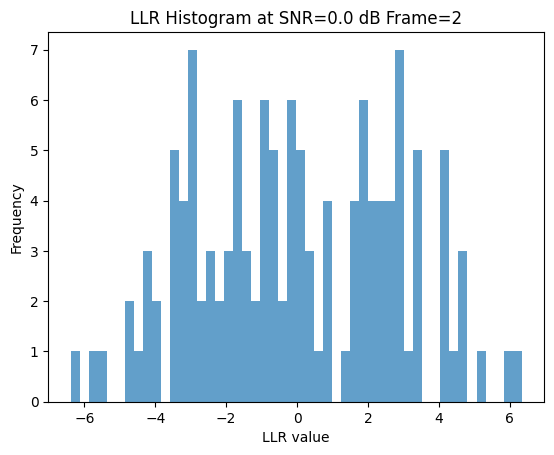

SNR=0.0 dB: BER=4.59e-01, BLER=1.00e+00
[DEBUG] SNR=0.5 dB, Frame=0
[DEBUG] LLR min/max: -7.095/8.044


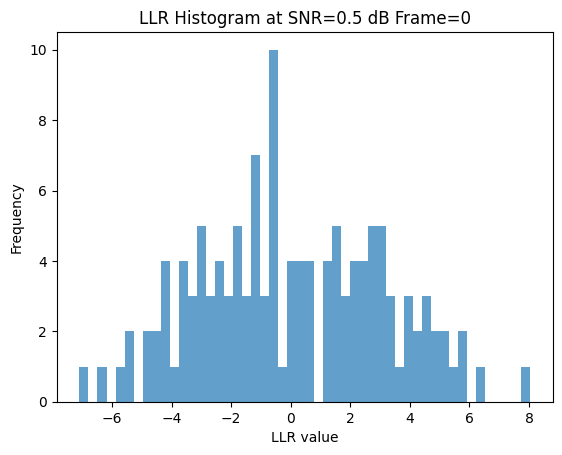

[DEBUG] SNR=0.5 dB, Frame=1
[DEBUG] LLR min/max: -6.946/7.950


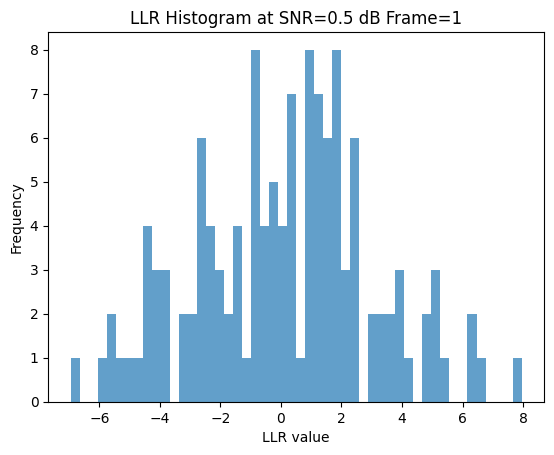

[DEBUG] SNR=0.5 dB, Frame=2
[DEBUG] LLR min/max: -8.223/5.973


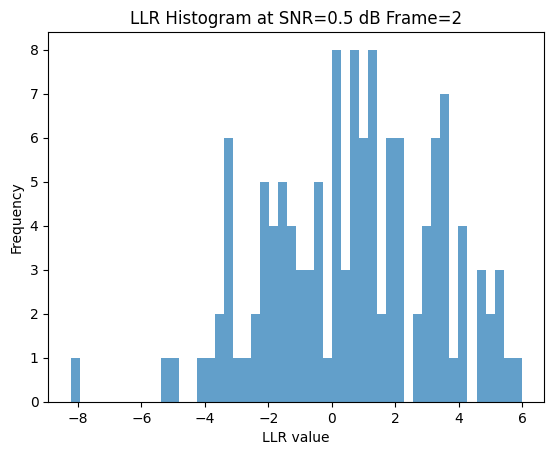

SNR=0.5 dB: BER=4.61e-01, BLER=1.00e+00
[DEBUG] SNR=1.0 dB, Frame=0
[DEBUG] LLR min/max: -7.223/6.134


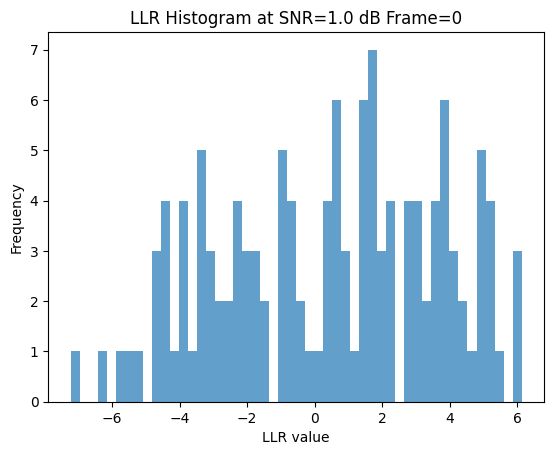

[DEBUG] SNR=1.0 dB, Frame=1
[DEBUG] LLR min/max: -6.874/8.837


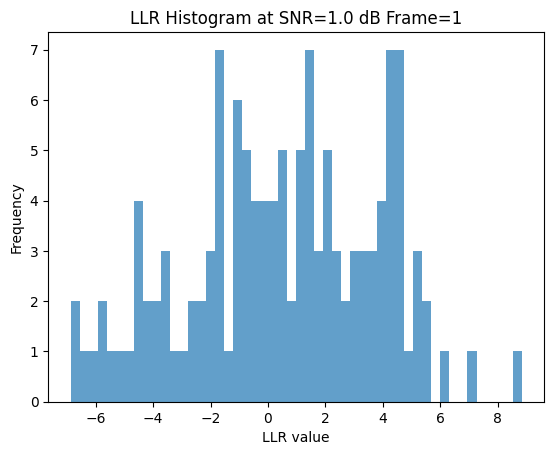

[DEBUG] SNR=1.0 dB, Frame=2
[DEBUG] LLR min/max: -6.703/6.413


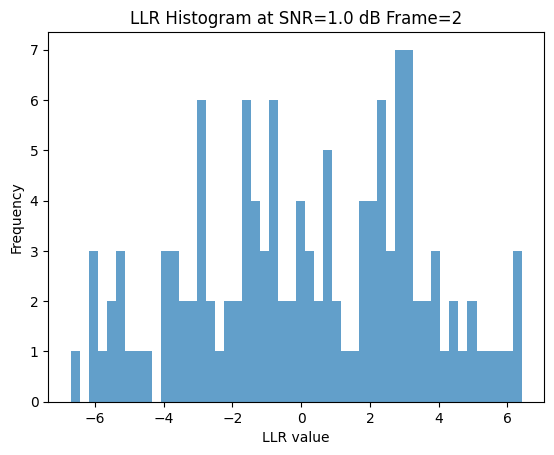

SNR=1.0 dB: BER=4.49e-01, BLER=1.00e+00
SNR=1.5 dB: BER=4.50e-01, BLER=1.00e+00
SNR=2.0 dB: BER=4.48e-01, BLER=1.00e+00
SNR=2.5 dB: BER=4.51e-01, BLER=1.00e+00
SNR=3.0 dB: BER=4.53e-01, BLER=1.00e+00
SNR=3.5 dB: BER=4.47e-01, BLER=1.00e+00
SNR=4.0 dB: BER=4.44e-01, BLER=1.00e+00
SNR=4.5 dB: BER=4.50e-01, BLER=1.00e+00
SNR=5.0 dB: BER=4.28e-01, BLER=1.00e+00
SNR=5.5 dB: BER=4.42e-01, BLER=1.00e+00
SNR=6.0 dB: BER=4.39e-01, BLER=1.00e+00
SNR=6.5 dB: BER=4.32e-01, BLER=1.00e+00
Running SCL decoder with list size 16...
[DEBUG] SNR=0.0 dB, Frame=0
[DEBUG] LLR min/max: -5.920/6.910


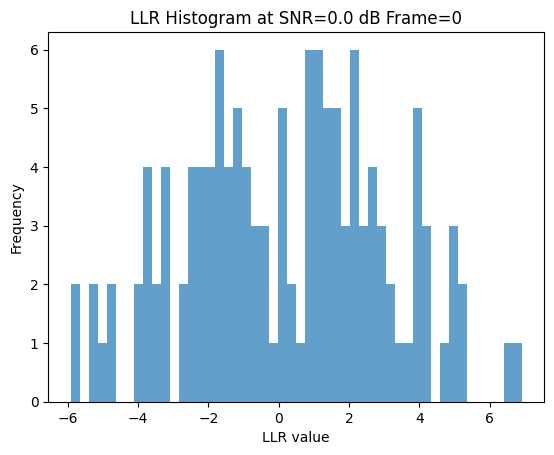

[DEBUG] SNR=0.0 dB, Frame=1
[DEBUG] LLR min/max: -8.719/7.376


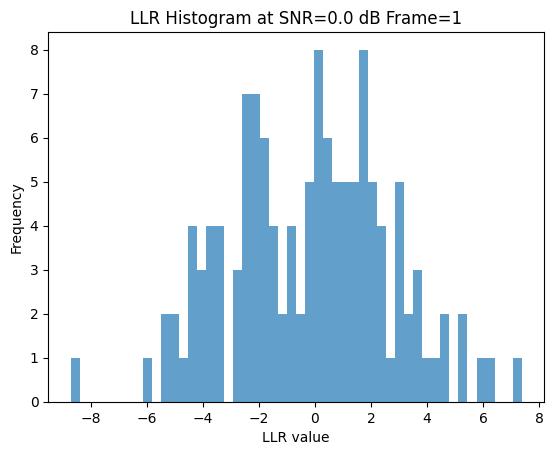

[DEBUG] SNR=0.0 dB, Frame=2
[DEBUG] LLR min/max: -6.085/6.802


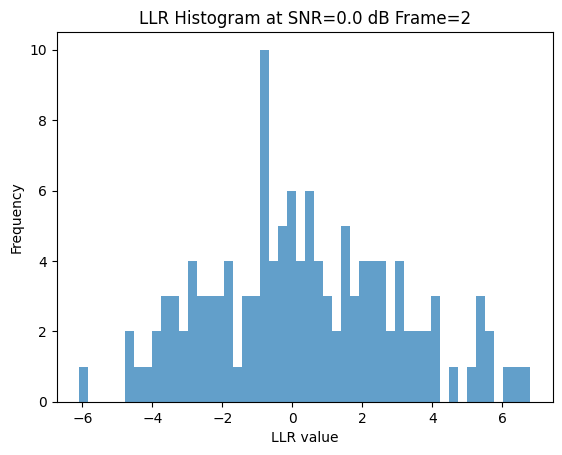

SNR=0.0 dB: BER=4.62e-01, BLER=1.00e+00
[DEBUG] SNR=0.5 dB, Frame=0
[DEBUG] LLR min/max: -7.566/6.563


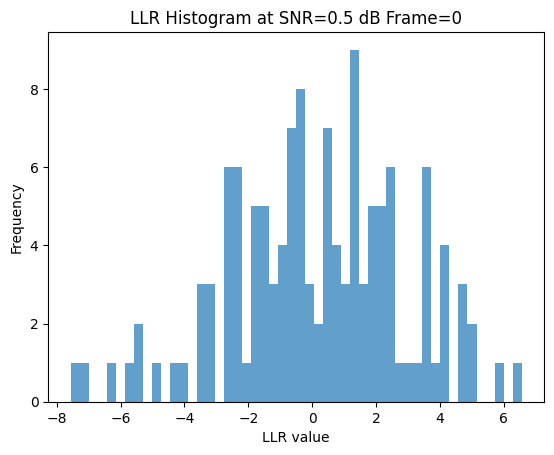

[DEBUG] SNR=0.5 dB, Frame=1
[DEBUG] LLR min/max: -8.600/8.095


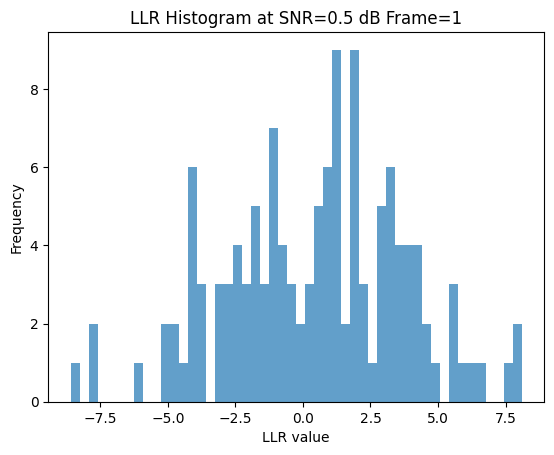

[DEBUG] SNR=0.5 dB, Frame=2
[DEBUG] LLR min/max: -7.126/6.466


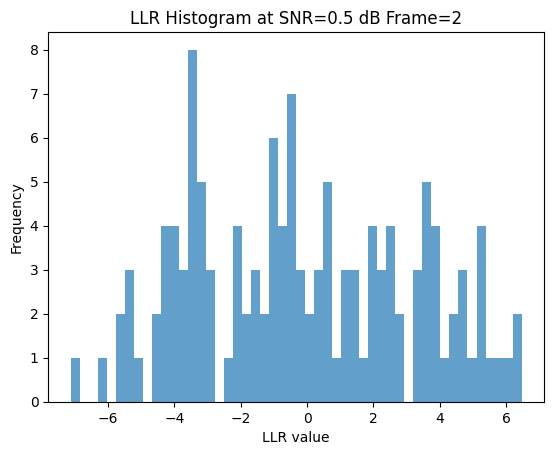

SNR=0.5 dB: BER=4.62e-01, BLER=1.00e+00
[DEBUG] SNR=1.0 dB, Frame=0
[DEBUG] LLR min/max: -8.618/8.912


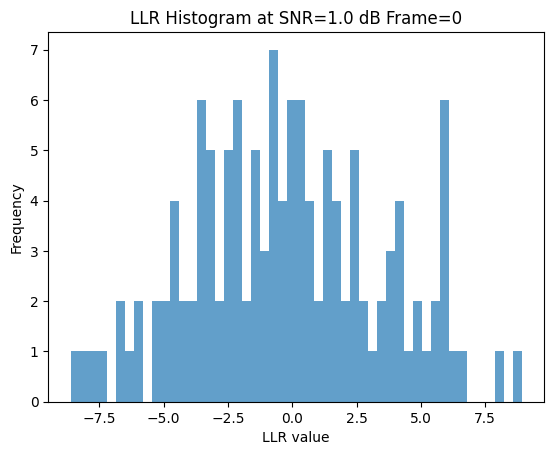

[DEBUG] SNR=1.0 dB, Frame=1
[DEBUG] LLR min/max: -7.497/8.221


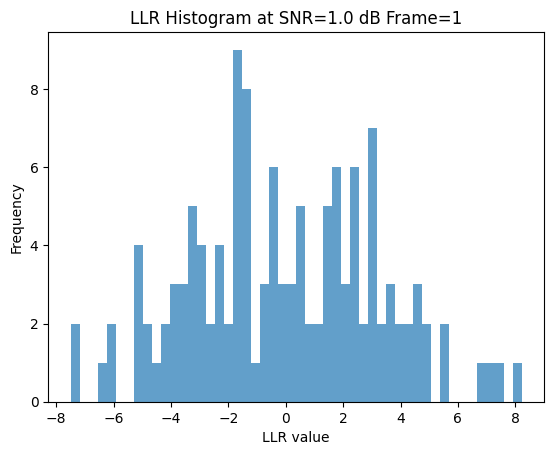

[DEBUG] SNR=1.0 dB, Frame=2
[DEBUG] LLR min/max: -6.937/7.133


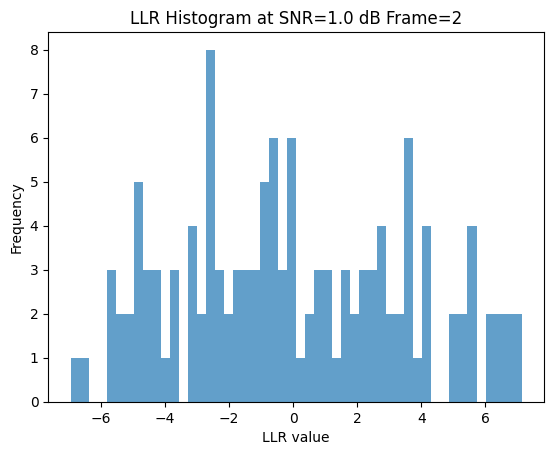

SNR=1.0 dB: BER=4.53e-01, BLER=1.00e+00
SNR=1.5 dB: BER=4.55e-01, BLER=1.00e+00
SNR=2.0 dB: BER=4.51e-01, BLER=1.00e+00
SNR=2.5 dB: BER=4.52e-01, BLER=1.00e+00
SNR=3.0 dB: BER=4.41e-01, BLER=1.00e+00
SNR=3.5 dB: BER=4.42e-01, BLER=1.00e+00
SNR=4.0 dB: BER=4.50e-01, BLER=1.00e+00
SNR=4.5 dB: BER=4.52e-01, BLER=1.00e+00
SNR=5.0 dB: BER=4.40e-01, BLER=1.00e+00
SNR=5.5 dB: BER=4.41e-01, BLER=1.00e+00
SNR=6.0 dB: BER=4.27e-01, BLER=1.00e+00
SNR=6.5 dB: BER=4.36e-01, BLER=1.00e+00
Running SCL decoder with list size 32...
[DEBUG] SNR=0.0 dB, Frame=0
[DEBUG] LLR min/max: -6.104/5.664


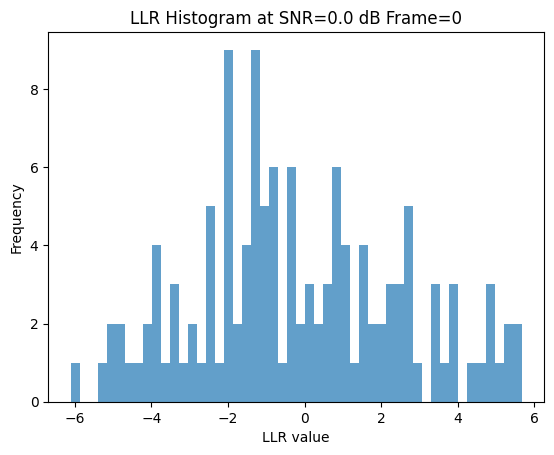

[DEBUG] SNR=0.0 dB, Frame=1
[DEBUG] LLR min/max: -7.916/6.660


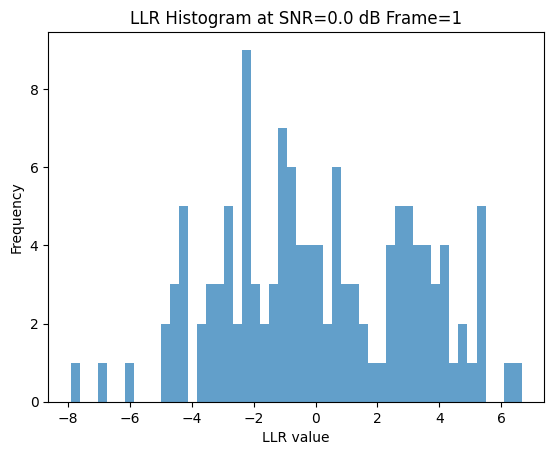

[DEBUG] SNR=0.0 dB, Frame=2
[DEBUG] LLR min/max: -7.036/6.385


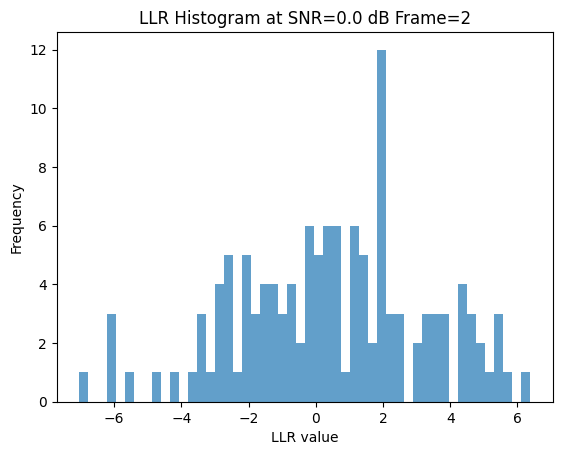

SNR=0.0 dB: BER=4.57e-01, BLER=1.00e+00
[DEBUG] SNR=0.5 dB, Frame=0
[DEBUG] LLR min/max: -6.071/7.212


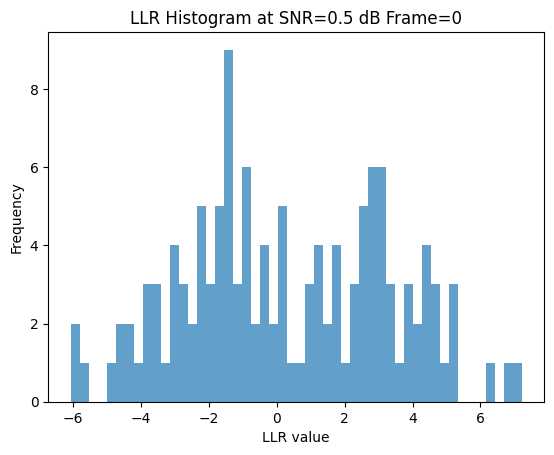

[DEBUG] SNR=0.5 dB, Frame=1
[DEBUG] LLR min/max: -7.032/6.736


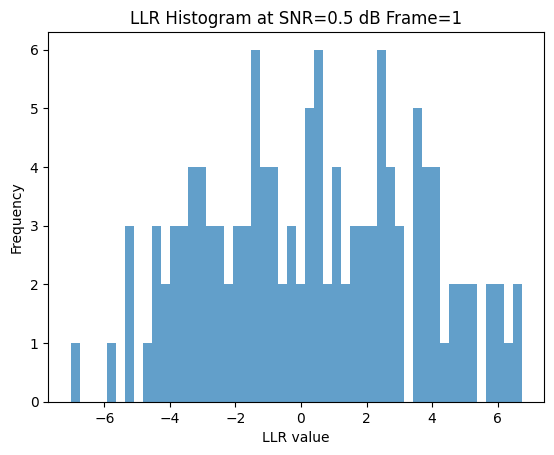

[DEBUG] SNR=0.5 dB, Frame=2
[DEBUG] LLR min/max: -5.964/5.708


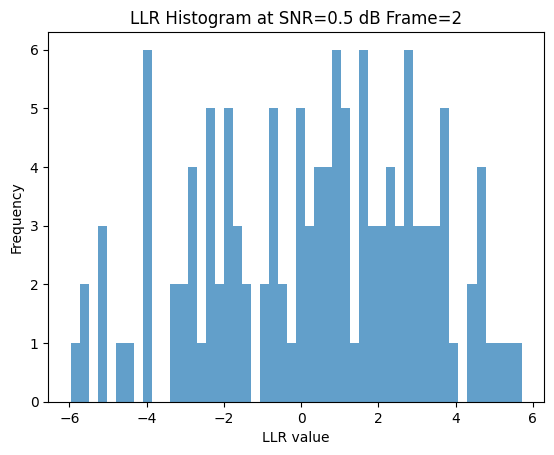

SNR=0.5 dB: BER=4.73e-01, BLER=1.00e+00
[DEBUG] SNR=1.0 dB, Frame=0
[DEBUG] LLR min/max: -9.137/8.335


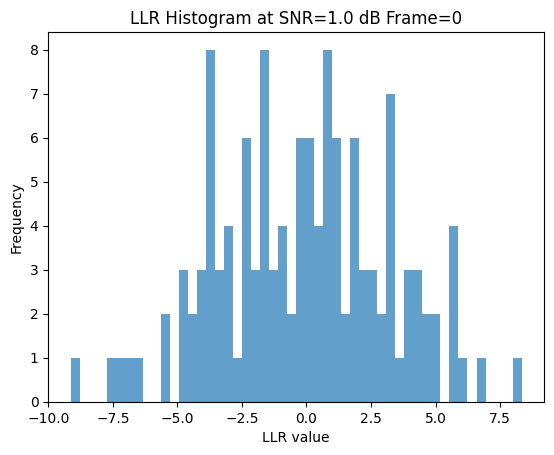

[DEBUG] SNR=1.0 dB, Frame=1
[DEBUG] LLR min/max: -6.687/7.585


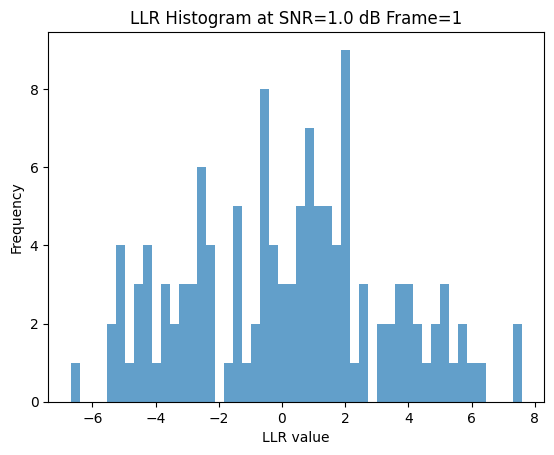

[DEBUG] SNR=1.0 dB, Frame=2
[DEBUG] LLR min/max: -7.475/7.283


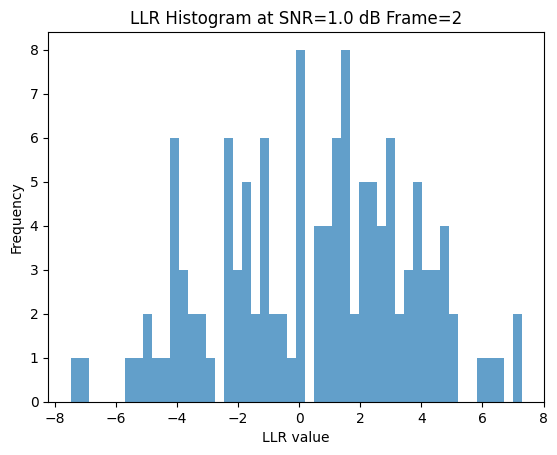

SNR=1.0 dB: BER=4.52e-01, BLER=1.00e+00
SNR=1.5 dB: BER=4.58e-01, BLER=1.00e+00
SNR=2.0 dB: BER=4.55e-01, BLER=1.00e+00
SNR=2.5 dB: BER=4.52e-01, BLER=1.00e+00
SNR=3.0 dB: BER=4.48e-01, BLER=1.00e+00
SNR=3.5 dB: BER=4.55e-01, BLER=1.00e+00
SNR=4.0 dB: BER=4.60e-01, BLER=1.00e+00
SNR=4.5 dB: BER=4.55e-01, BLER=1.00e+00
SNR=5.0 dB: BER=4.39e-01, BLER=1.00e+00
SNR=5.5 dB: BER=4.29e-01, BLER=1.00e+00
SNR=6.0 dB: BER=4.33e-01, BLER=1.00e+00
SNR=6.5 dB: BER=4.37e-01, BLER=1.00e+00
Evaluating RNN Decoder...
[DEBUG] SNR=0.0 dB, Frame=0
[DEBUG] LLR min/max: -7.865/5.897


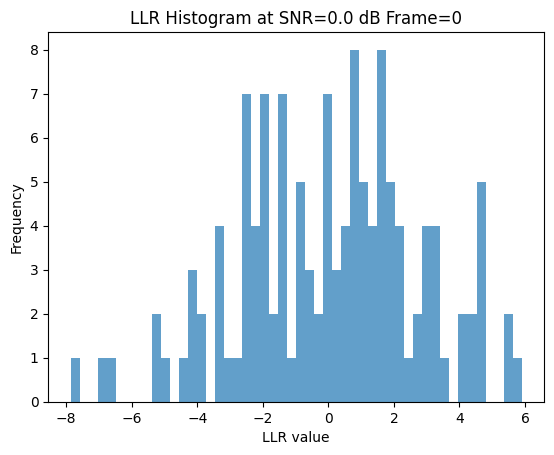

[DEBUG] SNR=0.0 dB, Frame=1
[DEBUG] LLR min/max: -6.106/6.831


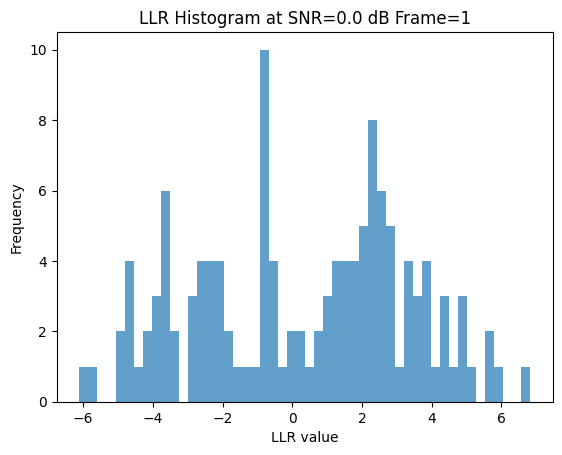

[DEBUG] SNR=0.0 dB, Frame=2
[DEBUG] LLR min/max: -5.695/7.830


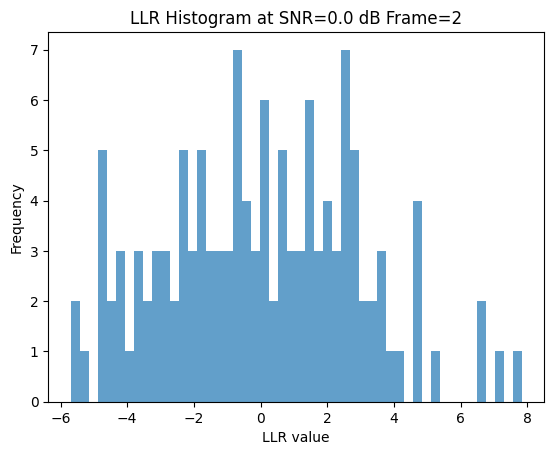

SNR=0.0 dB: BER=5.02e-01, BLER=1.00e+00
[DEBUG] SNR=0.5 dB, Frame=0
[DEBUG] LLR min/max: -9.980/7.877


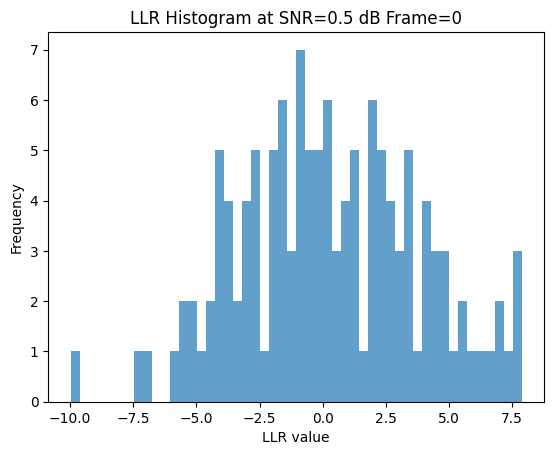

[DEBUG] SNR=0.5 dB, Frame=1
[DEBUG] LLR min/max: -8.693/6.950


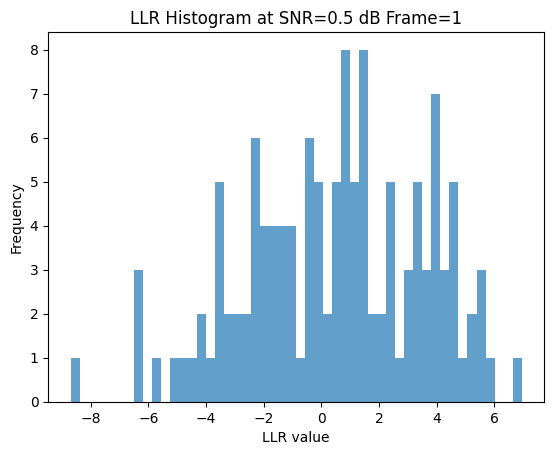

[DEBUG] SNR=0.5 dB, Frame=2
[DEBUG] LLR min/max: -7.792/9.441


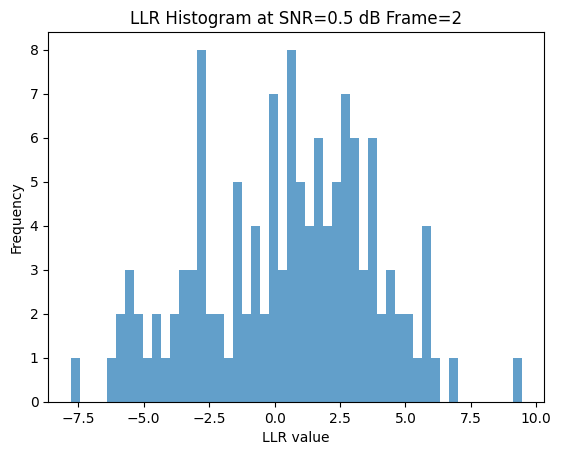

SNR=0.5 dB: BER=4.89e-01, BLER=1.00e+00
[DEBUG] SNR=1.0 dB, Frame=0
[DEBUG] LLR min/max: -7.848/7.401


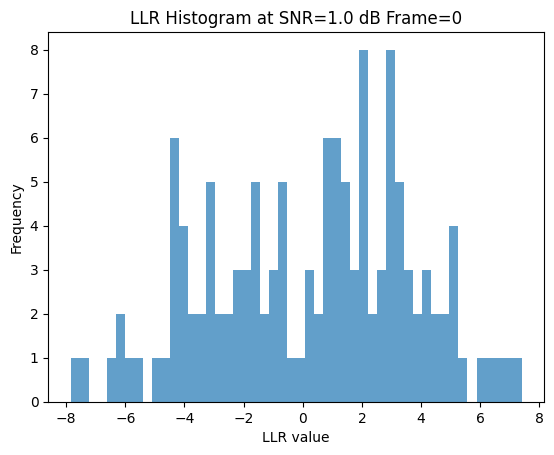

[DEBUG] SNR=1.0 dB, Frame=1
[DEBUG] LLR min/max: -8.973/8.221


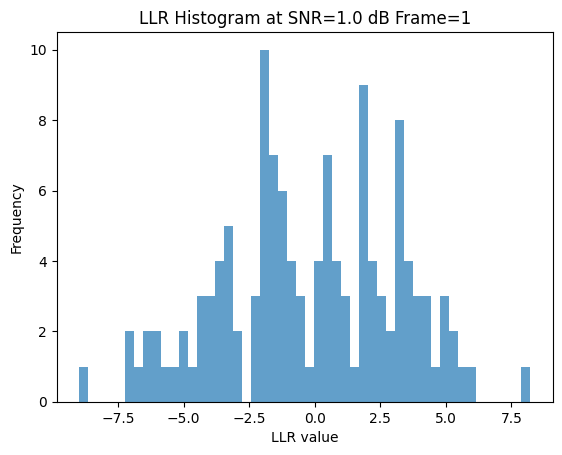

[DEBUG] SNR=1.0 dB, Frame=2
[DEBUG] LLR min/max: -6.110/9.708


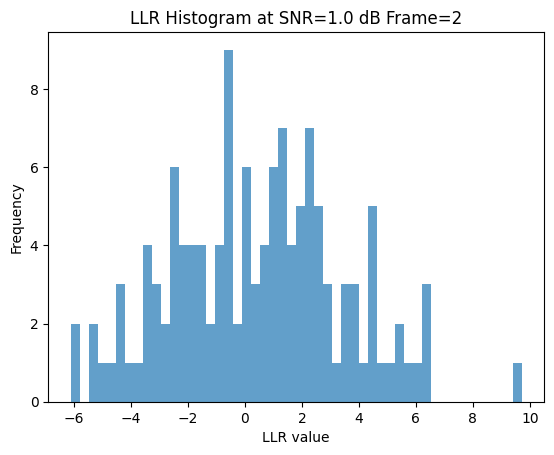

SNR=1.0 dB: BER=4.95e-01, BLER=1.00e+00
SNR=1.5 dB: BER=5.00e-01, BLER=1.00e+00
SNR=2.0 dB: BER=5.10e-01, BLER=1.00e+00
SNR=2.5 dB: BER=5.03e-01, BLER=1.00e+00
SNR=3.0 dB: BER=4.99e-01, BLER=1.00e+00
SNR=3.5 dB: BER=4.92e-01, BLER=1.00e+00
SNR=4.0 dB: BER=5.02e-01, BLER=1.00e+00
SNR=4.5 dB: BER=5.00e-01, BLER=1.00e+00
SNR=5.0 dB: BER=5.12e-01, BLER=1.00e+00
SNR=5.5 dB: BER=4.93e-01, BLER=1.00e+00
SNR=6.0 dB: BER=5.03e-01, BLER=1.00e+00
SNR=6.5 dB: BER=5.00e-01, BLER=1.00e+00


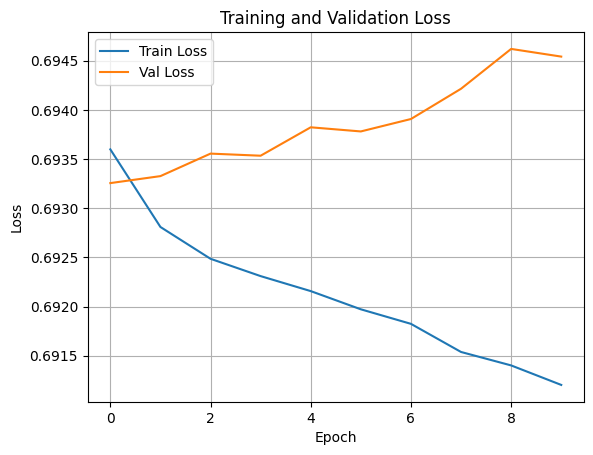

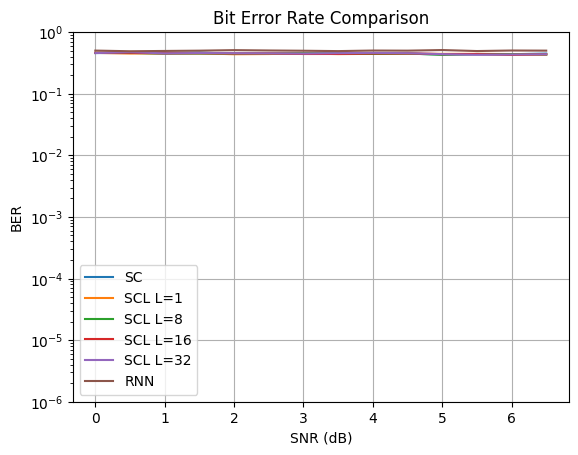

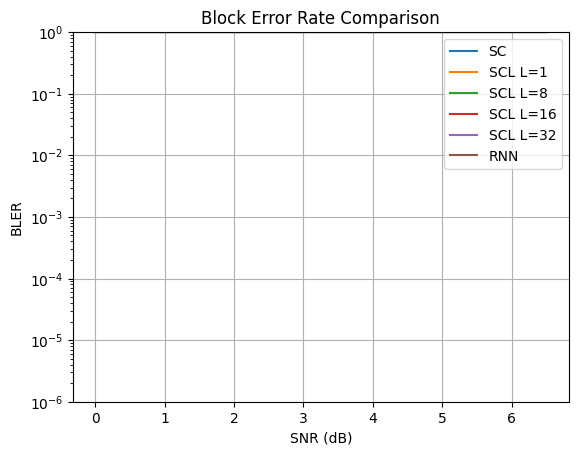

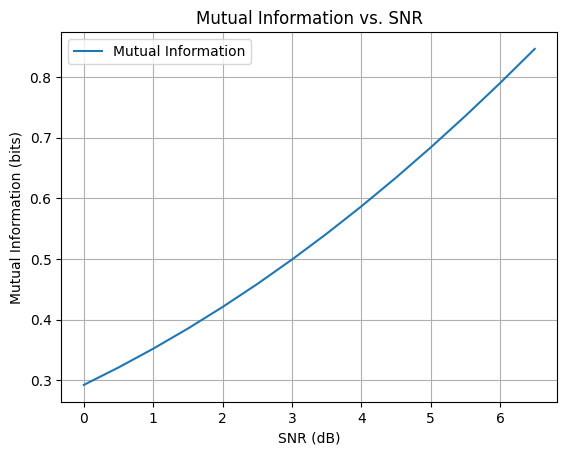

In [10]:
#latest modification
#RM-polar codes and machine learning simulations
#06/21/2025
import numpy as np
#import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'  # This disables TF from using GPU
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam


# List and configure TensorFlow GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Enable memory growth for each GPU (prevents memory hogging)
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("TensorFlow GPU memory growth enabled.")
    except RuntimeError as e:
        print("TensorFlow GPU initialization error:", e)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
import heapq
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import heapq  # Also needed for SCL decoding
import matplotlib.pyplot as plt  # Needed for plotting



#################################################################################

#Lates RM-polar
# Configuration
# ---- Configuration ----
BLOCK_LENGTH = 128
INFO_BITS = 64
RM_ORDER = 3
SNR_RANGE = np.arange(0, 7, 0.5)
LIST_SIZES = [1, 8, 16, 32]
NUM_FRAMES = 100
BATCH_SIZE = 64
EPOCHS = 10
LEARNING_RATE = 0.001  # Add this for clarity
SNR_DB = 2.0  # Signal-to-noise ratio in dB

# BPSK Modulation and AWGN Channel
def bpsk_modulate(x):
    return 1 - 2 * x

def awgn_noise(x, snr_db, rate):
    snr_linear = 10 ** (snr_db / 10)
    sigma = np.sqrt(1 / (2 * rate * snr_linear))
    return x + sigma * np.random.randn(*x.shape)

def llr_awgn(y, snr_db, rate):
    snr_linear = 10 ** (snr_db / 10)
    sigma2 = 1 / (2 * rate * snr_linear)
    return 2 * y / sigma2

# RM-Polar Construction
def get_rm_polar_frozen_indices(N, K, rm_order):
    n = int(np.log2(N))
    indices = np.arange(N)
    bin_indices = np.array([list(np.binary_repr(i, n)) for i in indices], dtype=int)
    hamming_weights = bin_indices.sum(axis=1)
    rm_candidates = indices[hamming_weights >= rm_order]

    # Bhattacharyya parameters (assuming perfect channel)
    Z = np.zeros(N)
    Z[0] = 2 ** n
    for i in range(1, N):
        Z[i] = Z[i // 2] / 2 if i % 2 == 0 else (Z[i // 2 - 1] + Z[i // 2]) / 2

    polar_order = np.argsort(Z)
    filtered = [i for i in polar_order if i in rm_candidates]
    info_indices = np.array(filtered[:K])
    frozen_indices = np.setdiff1d(np.arange(N), info_indices)
    return frozen_indices

# Polar Encoder
def polar_encode(u, frozen_indices):
    N = len(frozen_indices) + len(u)
    x = np.zeros(N, dtype=int)
    info_idx = np.setdiff1d(np.arange(N), frozen_indices)
    x[info_idx] = u
    n = int(np.log2(N))
    for i in range(n):
        step = 2 ** i
        for j in range(0, N, 2 * step):
            for k in range(step):
                x[j + k] ^= x[j + k + step]
    return x

# SC Decoder
def sc_decode(llr, frozen_indices):
    N = len(llr)
    u_hat = np.zeros(N, dtype=int)
    info_idx = np.setdiff1d(np.arange(N), frozen_indices)
    u_hat[frozen_indices] = 0
    u_hat[info_idx] = (llr[info_idx] < 0).astype(int)
    return u_hat[info_idx]

# SCL Decoder
def scl_decode(llr, frozen_indices, L):
    N = len(llr)
    paths = [(0.0, np.zeros(N, dtype=int))]
    info_idx = np.setdiff1d(np.arange(N), frozen_indices)
    for i in range(N):
        new_paths = []
        for pm, u in paths:
            if i in frozen_indices:
                u0 = u.copy()
                u0[i] = 0
                pm_new = pm + np.log1p(np.exp(-abs(llr[i])))
                new_paths.append((pm_new, u0))
            else:
                for bit in [0, 1]:
                    u_new = u.copy()
                    u_new[i] = bit
                    llr_i = llr[i]
                    pm_new = pm + (np.log1p(np.exp(-abs(llr_i))) if bit != (llr_i < 0) else 0)
                    new_paths.append((pm_new, u_new))
        paths = heapq.nsmallest(L, new_paths)
    best_path = min(paths, key=lambda x: x[0])[1]
    return best_path[info_idx]

# RM-Polar Code Class
class RMPolarCode:
    def __init__(self, N=128, K=64, rm_order=3, snr_db=2.0):  # Correct setup
        self.N = N
        self.K = K
        self.rm_order = rm_order
        self.rate = K / N
        self.snr_db = snr_db  # Initialize snr_db
        self.frozen_indices = get_rm_polar_frozen_indices(N, K, rm_order)

    def polar_encode(self, u):
        return polar_encode(u, self.frozen_indices)

    def calculate_mi(self, snr_db):
        self.snr_db = snr_db  # Optionally set snr_db
        snr_linear = 10 ** (snr_db / 10)
        return 0.5 * np.log2(1 + snr_linear * self.rate)



###############################################################################

# Define your RNN model with the correct input size
class RNNDecoder(nn.Module):
    def __init__(self, input_size=1, hidden_size=128, output_size=64):
        super(RNNDecoder, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
     output, _ = self.lstm(x)
     output = self.fc(output[:, -1, :])
     return torch.sigmoid(output)  # Apply sigmoid activation
# ---- RNN Decoder ----
##########################################################################
#latest train decoder
def train_rnn_decoder(code, train_loader, val_loader, test_loader, epochs=30, lr=0.001, device='cpu'):
    model = RNNDecoder(input_size=1, hidden_size=128, output_size=code.K).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCELoss()
    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for batch_X, batch_Y in train_loader:
            batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)
            optimizer.zero_grad()
            # No sigmoid here, BCELoss with logits is more stable.
            # But since the model already has sigmoid, keep it for now.
            # Ideally, remove sigmoid from forward and use nn.BCEWithLogitsLoss
            preds = model(batch_X)
            # print(f"Train Preds shape: {preds.shape}, Targets shape: {batch_Y.shape}")  # Debug shapes
            # print(f"Preds min/max: {preds.min()}/{preds.max()}")  # Debug values
            loss = criterion(preds, batch_Y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        train_losses.append(epoch_loss / len(train_loader))

        model.eval()
        with torch.no_grad():
            val_loss = 0
            for val_X, val_Y in val_loader:
                val_X, val_Y = val_X.to(device), val_Y.to(device)
                # No sigmoid here
                val_preds = model(val_X)
                # print(f"Val Preds shape: {val_preds.shape}, Targets shape: {val_Y.shape}")  # Debug shapes
                loss = criterion(val_preds, val_Y)
                val_loss += loss.item()
            val_losses.append(val_loss / len(val_loader))

        print(f"Epoch {epoch+1}: Train Loss={train_losses[-1]:.4f}, Val Loss={val_losses[-1]:.4f}")

    return model, train_losses, val_losses
###########################################################################

# ---- ML Decoder Utilities ----

#Latest data loader

# Reshape data in get_dataloaders to match the expected input size
#latest data generation
# Data generation
def generate_data(num_samples, timesteps, features):
    X = np.random.randn(num_samples, timesteps, features)
    y = np.random.randint(0, 2, (num_samples, 1))
    return X, y

# Data preparation
timesteps = 10
features = 3
X_train_tf, y_train_tf = generate_data(1000, timesteps, features)
X_val_tf, y_val_tf = generate_data(200, timesteps, features)
X_test_tf, y_test_tf = generate_data(200, timesteps, features)

# RNN Model Configuration
model_tf = Sequential()
model_tf.add(LSTM(128, input_shape=(timesteps, features), return_sequences=False))
model_tf.add(Dense(1, activation='sigmoid'))

# Compile Model
learning_rate_tf = 0.001
model_tf.compile(optimizer=Adam(learning_rate=learning_rate_tf), loss='binary_crossentropy', metrics=['accuracy'])

# Train Model
model_tf.fit(X_train_tf, y_train_tf, epochs=20, batch_size=32, validation_data=(X_val_tf, y_val_tf))

# Prediction & Calculating BER and BLER
def calculate_ber(y_true, y_pred):
    errors = np.sum(y_true != y_pred)
    total_bits = y_true.size
    return errors / total_bits

def calculate_bler(y_true, y_pred):
    block_errors = np.sum(np.any(y_true != y_pred, axis=1))
    num_blocks = y_true.shape[0]
    return block_errors / num_blocks

# Make Predictions
y_pred_probs_tf = model_tf.predict(X_test_tf)
y_pred_tf = np.round(y_pred_probs_tf)

ber_tf = calculate_ber(y_test_tf, y_pred_tf)
bler_tf = calculate_bler(y_test_tf, y_pred_tf)

print(f"Keras Model BER: {ber_tf}, BLER: {bler_tf}")
###################################################################





#######################################################
# Reshape data in get_dataloaders to match the expected input size
def get_dataloaders(code, batch_size):
    num_samples_train = 1000
    num_samples_val = 100
    num_samples_test = 100

    # Simulate data
    # The PyTorch RNN expects input shape (batch_size, sequence_length, input_size)
    # Here, the sequence_length is code.N and input_size is 1.
    X_train = np.random.randn(num_samples_train, code.N, 1)
    y_train = np.random.randint(0, 2, (num_samples_train, code.K))

    X_val = np.random.randn(num_samples_val, code.N, 1)
    y_val = np.random.randint(0, 2, (num_samples_val, code.K))

    # For the RNN decoder evaluation, we will simulate data within the evaluate_decoder function
    # This avoids generating potentially massive datasets if NUM_FRAMES is large.
    # We will still return a test loader here for completeness, but the evaluation
    # uses on-the-fly data generation.
    X_test = np.random.randn(num_samples_test, code.N, 1)
    y_test = np.random.randint(0, 2, (num_samples_test, code.K))


    # Create TensorDatasets
    train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
    val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))
    test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)) # Not used in evaluate_decoder

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) # Not used in evaluate_decoder

    return train_loader, val_loader, test_loader
####################################################
def evaluate_decoder(code, decoder_func, snrs, L=1, model=None, device='cpu'):
    frozen_indices = code.frozen_indices
    rate = code.rate
    ber_curve, bler_curve = [], []

    for snr_idx, snr in enumerate(snrs):
        bit_errors, block_errors, total_bits = 0, 0, 0
        for frame_idx in range(NUM_FRAMES):
            # Generate random info bits
            u = np.random.randint(0, 2, code.K)
            x = code.polar_encode(u)
            y = bpsk_modulate(x)
            y_noisy = awgn_noise(y, snr, rate)

            # Improved LLR calculation with clipping
            snr_linear = 10 ** (snr / 10)
            sigma2 = 1 / (2 * rate * snr_linear)
            llrs = (2 / sigma2) * y_noisy
            # Optional clipping for numerical stability:
            llrs = np.clip(llrs, -100, 100)

            # Debug prints and histogram for first 3 frames and first 3 SNRs
            if snr_idx < 3 and frame_idx < 3:
                print(f"[DEBUG] SNR={snr} dB, Frame={frame_idx}")
                print(f"[DEBUG] LLR min/max: {llrs.min():.3f}/{llrs.max():.3f}")
                import matplotlib.pyplot as plt
                plt.hist(llrs, bins=50, alpha=0.7)
                plt.title(f"LLR Histogram at SNR={snr} dB Frame={frame_idx}")
                plt.xlabel("LLR value")
                plt.ylabel("Frequency")
                plt.show()

            if decoder_func == "sc":
                u_hat = sc_decode(llrs, frozen_indices)
            elif decoder_func == "scl":
                u_hat = scl_decode(llrs, frozen_indices, L)
            elif decoder_func == "rnn" and model is not None:
                y_noisy_tensor = torch.tensor(llrs, dtype=torch.float32).unsqueeze(0).unsqueeze(-1).to(device)
                with torch.no_grad():
                    u_hat = model(y_noisy_tensor).squeeze().round().cpu().numpy().astype(int)
                # Safety reshape
                if u_hat.ndim != 1 or u_hat.shape[0] != code.K:
                    u_hat = u_hat.reshape(-1)[:code.K]
            else:
                raise ValueError("Invalid decoder function or missing model for RNN.")

            # Error counting only if shapes match
            if u_hat.shape == u.shape:
                bit_errors += np.sum(u != u_hat)
                block_errors += int(not np.array_equal(u, u_hat))
                total_bits += code.K
            else:
                print(f"[WARN] Shape mismatch at SNR={snr}: u_hat.shape={u_hat.shape}, u.shape={u.shape}")

        ber_curve.append(bit_errors / total_bits if total_bits > 0 else np.nan)
        bler_curve.append(block_errors / NUM_FRAMES if NUM_FRAMES > 0 else np.nan)
        print(f"SNR={snr:.1f} dB: BER={ber_curve[-1]:.2e}, BLER={bler_curve[-1]:.2e}")

    return ber_curve, bler_curve
#####################################################





#Latest main()
def main():

    # Choose CUDA explicitly or fallback to CPU
    USE_CUDA = True
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Initialize the RMPolarCode with snr_db
    code = RMPolarCode(N=BLOCK_LENGTH, K=INFO_BITS, rm_order=RM_ORDER, snr_db=SNR_DB)

    # Prepare data loaders (for PyTorch RNN training)
    train_loader, val_loader, test_loader = get_dataloaders(code, batch_size=BATCH_SIZE)

    # Train and Evaluate RNN Decoder
    print("Training RNN Decoder...")
    model, train_losses, val_losses = train_rnn_decoder(
        code, train_loader, val_loader, test_loader, epochs=EPOCHS, lr=LEARNING_RATE, device=device
    )


    print("Running SC decoder...")
    ber_sc, bler_sc = evaluate_decoder(code, decoder_func="sc", snrs=SNR_RANGE)
    np.savez("ber_sc_results.npz", ber=ber_sc, bler=bler_sc)
   # ber_sc, bler_sc = evaluate_decoder(code, decoder_func="sc", snrs=SNR_RANGE, code=code) # Pass code object

 #   ber_scl_all, bler_scl_all = {}, {}
  #  for L in LIST_SIZES:
   #   print(f"Running SCL decoder with list size {L}...")
    #  ber_scl, bler_scl = evaluate_decoder(code, decoder_func="scl", snrs=SNR_RANGE, L=L)
     # ber_scl_all[L] = ber_scl
      #bler_scl_all[L] = bler_scl
      #print("Running SCL decoder...")
   # ber_sc, bler_sc = evaluate_decoder(code, decoder_func="sc", snrs=SNR_RANGE)
   # ber_scl, bler_scl = evaluate_decoder(code, decoder_func="scl", snrs=SNR_RANGE, L=L)
    ber_scl_all, bler_scl_all = {}, {}
    for L in LIST_SIZES:
     print(f"Running SCL decoder with list size {L}...")
     ber_scl, bler_scl = evaluate_decoder(code, decoder_func="scl", snrs=SNR_RANGE, L=L)
     ber_scl_all[L] = ber_scl
     bler_scl_all[L] = bler_scl
   # Save all SCL results together
    np.savez("ber_scl_results.npz", ber=ber_scl_all, bler=bler_scl_all)

    print("Evaluating RNN Decoder...")
    # For the RNN evaluation, we pass the trained PyTorch model
    #ber_rnn, bler_rnn = evaluate_decoder(code, decoder_func="rnn", snrs=SNR_RANGE, model=model, device=device, code=code) # Pass code object
    ber_rnn, bler_rnn = evaluate_decoder(code, decoder_func="rnn", snrs=SNR_RANGE, model=model, device=device)
    np.savez("ber_rnn_results.npz", ber=ber_rnn, bler=bler_rnn)

    # Plot Training/Validation Loss
    plt.figure()
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.grid(True)
    plt.legend()
    plt.show()

    # Plot BER Comparison
    plt.figure()
    plt.semilogy(SNR_RANGE, ber_sc, label="SC")
    for L in LIST_SIZES:
        plt.semilogy(SNR_RANGE, ber_scl_all[L], label=f"SCL L={L}")
    plt.semilogy(SNR_RANGE, ber_rnn, label="RNN")
    plt.xlabel("SNR (dB)")
    plt.ylabel("BER")
    plt.ylim(1e-6, 1)
    plt.title("Bit Error Rate Comparison")
    plt.grid(True)
    plt.legend()
    plt.show()

    # Plot BLER Comparison
    plt.figure()
    plt.semilogy(SNR_RANGE, bler_sc, label="SC")
    for L in LIST_SIZES:
        plt.semilogy(SNR_RANGE, bler_scl_all[L], label=f"SCL L={L}")
    plt.semilogy(SNR_RANGE, bler_rnn, label="RNN")
    plt.xlabel("SNR (dB)")
    plt.ylabel("BLER")
    plt.ylim(1e-6, 1)
    plt.title("Block Error Rate Comparison")
    plt.grid(True)
    plt.legend()
    plt.show()

    # Plot Mutual Information
    plt.figure()
    mi_values = [code.calculate_mi(snr) for snr in SNR_RANGE]
    plt.plot(SNR_RANGE, mi_values, label='Mutual Information')
    plt.xlabel('SNR (dB)')
    plt.ylabel('Mutual Information (bits)')
    plt.title('Mutual Information vs. SNR')
    plt.grid(True)
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main()